# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# Loading MNIST DataSets

In [3]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')


In [4]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [6]:
# Check the first few rows of sample_submission.csv to inspect the format
print(sample_submission.head())

   ImageId  Label
0        1      0
1        2      0
2        3      0
3        4      0
4        5      0


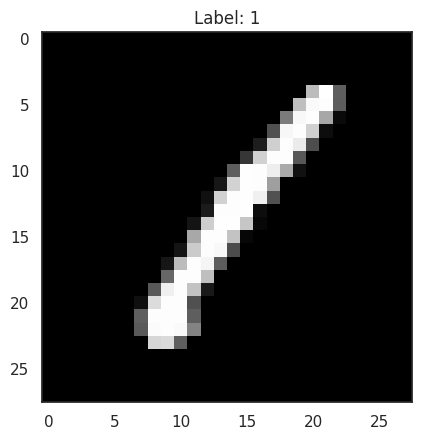

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Convert a single row of pixel values back into an image
image = train.iloc[0, 1:].values  # First row (excluding the label)
image = image.reshape(28, 28)  # Reshape to 28x28 image

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {train.iloc[0, 0]}")  # Display the label
plt.show()


# Data preparation

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [9]:
# Convert pandas DataFrame to numpy array and reshape
test = test.to_numpy().reshape(-1, 28, 28, 1)
# Directly reshape if test is already a numpy array
test = test.reshape(-1, 28, 28, 1)



In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

# Data Splitting

In [11]:
# Set the random seed
random_seed = 2

In [12]:
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)

In [14]:
import numpy as np

# Check for NaN values in a NumPy array
print(f"Number of NaN values in X_train: {np.isnan(X_train).sum()}")
print(f"Number of NaN values in y_train: {np.isnan(y_train).sum()}")


Number of NaN values in X_train: 668
Number of NaN values in y_train: 0


In [16]:
# Replace NaN values with the mean of the array
X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))


In [23]:
# Reshape the data to (num_samples, height, width, channels)
X_train = X_train.reshape(-1, 28, 28, 1)

# If you also have a validation or test set, reshape them too
X_val = X_val.reshape(-1, 28, 28, 1)


# Model Definition

In [17]:
# Set the CNN model

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [30]:
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


In [31]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#  Train the Model

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-6)

In [33]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

#  Data augmentation

In [34]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [35]:
# Fit the model using fit (not fit_generator)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])

# Get the final accuracy from the training history
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 - 6s - 521ms/step - accuracy: 0.8011 - loss: 0.5996 - val_accuracy: 0.9478 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


11/11 - 2s - 183ms/step - accuracy: 0.7523 - loss: 0.7443 - val_accuracy: 0.9739 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 3/10
11/11 - 2s - 189ms/step - accuracy: 0.7983 - loss: 0.5867 - val_accuracy: 0.9913 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 4/10
11/11 - 0s - 17ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9913 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 5/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 - 3s - 268ms/step - accuracy: 0.8125 - loss: 0.5422 - val_accuracy: 0.9913 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 6/10
11/11 - 3s - 265ms/step - accuracy: 0.8204 - loss: 0.5459 - val_accuracy: 0.9826 - val_loss: 0.0808 - learning_rate: 0.0010
Epoch 7/10
11/11 - 3s - 281ms/step - accuracy: 0.8523 - loss: 0.5175 - val_accuracy: 0.9913 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 8/10
11/11 - 0s - 18ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9913 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 9/10
11/11 - 2s - 201ms/step - accuracy: 0.8750 - loss: 0.4297 - val_accuracy: 1.0000 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 10/10
11/11 - 2s - 178ms/step - accuracy: 0.8793 - loss: 0.3703 - val_accuracy: 0.9739 - val_loss: 0.0601 - learning_rate: 0.0010
Final Training Accuracy: 87.93%
Final Validation Accuracy: 97.39%


# Evaluate and Test Predictions

In [36]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


In [37]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [45]:
from sklearn.metrics import classification_report


# Ensure the test data is in the correct shape (e.g., 28x28x1 for grayscale images)
test = test.reshape(-1, 28, 28, 1)

# Predict the results using the trained model
results = model.predict(test)

# Select the index with the maximum probability for each prediction
results = np.argmax(results, axis=1)

# Convert the predictions into a pandas Series
results = pd.Series(results, name="Label")


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


# Visualize Results

In [41]:
import pandas as pd
output = pd.DataFrame({"ImageId": range(1, len(y_pred_classes) + 1), "Label": y_pred_classes})
output.to_csv("submission.csv", index=False)


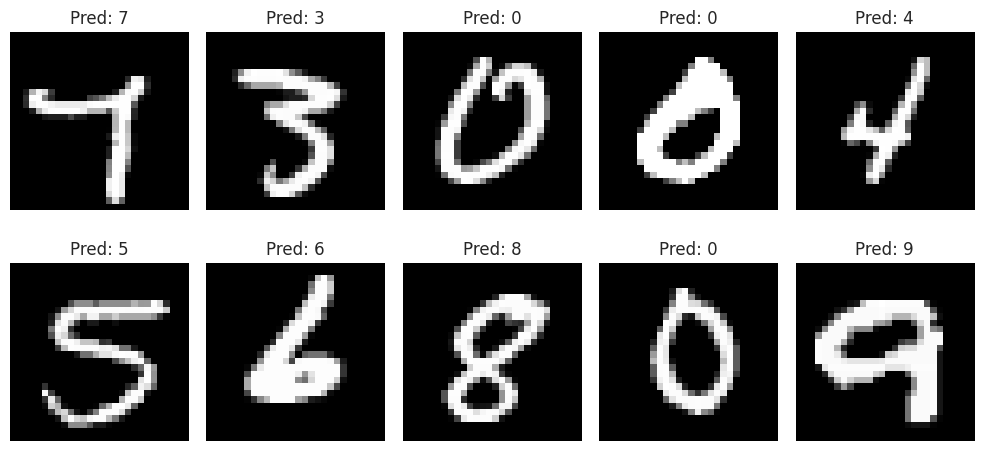

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a number of images to visualize (e.g., 10 random images)
num_images = 10

# Select random indices for images
indices = np.random.choice(len(test), num_images, replace=False)

# Create a plot with 1 row and num_images columns
plt.figure(figsize=(10, 5))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)  # Arrange images in 2 rows and 5 columns
    plt.imshow(test[idx].reshape(28, 28), cmap='gray')  # Reshape back to 28x28 for visualization
    plt.title(f"Pred: {results[idx]}")
    plt.axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()



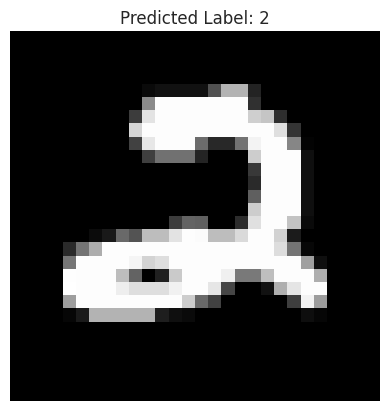

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Choose the index of the image you want to visualize from the test set
index = 0  # Change this to the specific index of the test image you want to test

# Reshape the image to 28x28 and display it (since it was reshaped to (28, 28, 1))
plt.imshow(test[index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted Label: {results[index]}")
plt.axis('off')  # Hide axis labels
plt.show()


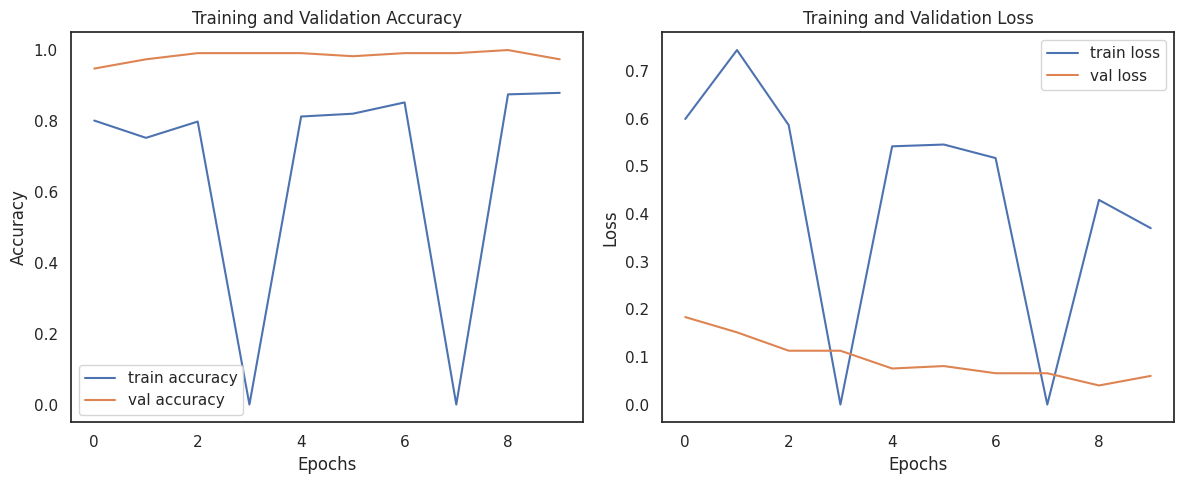

In [48]:
# Visualizing the training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



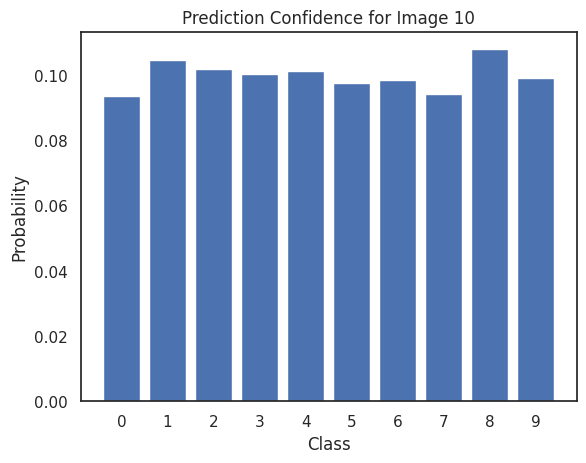

In [50]:
# Get predicted probabilities for each class
prediction_probs = prediction[0]

# Display the probabilities for each class
plt.bar(range(10), prediction_probs)
plt.xticks(range(10))
plt.title(f'Prediction Confidence for Image {image_index + 1}')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.show()
